Enter the stock name (e.g., CSX): CSX


C:\Windows\Temp\ipykernel_13460\1167487816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp']).dt.date


Enter the date for prediction (YYYY-MM-DD): 2024-11-25
Using the closest available date: 2024-11-25 for prediction.


C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0733
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.5181e-04
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.7792e-04
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.7388e-04
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.4739e-04
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.1397e-04
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.6502e-04
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.8715e-04
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.7539e-04
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.0779e-04
Epoch 13/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.1147e-04
Epoch 14/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 6.0535e-04
Epoch 15/20
76/76 ━━━━━━━━━

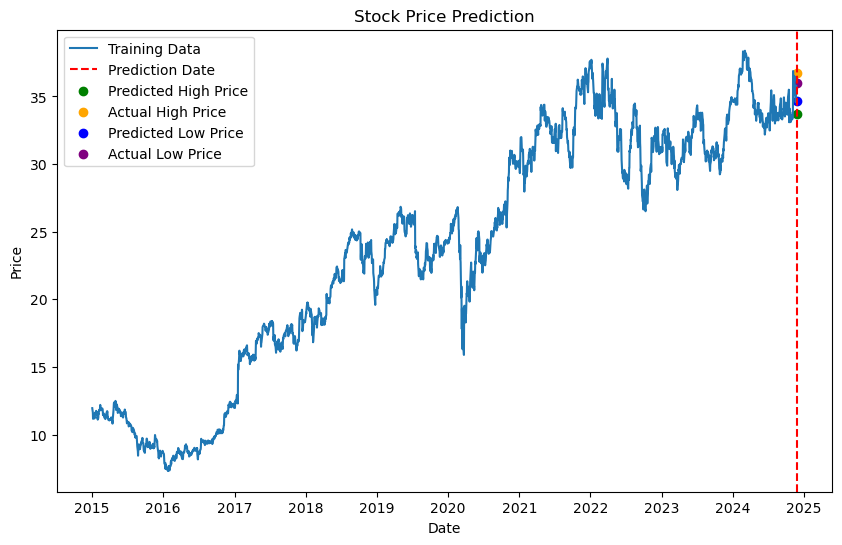

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Function to preprocess the stock data
def preprocess_stock_data(file_path, stock_name):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Standardize stock name and user input to avoid case sensitivity or whitespace issues
    df['stockname'] = df['stockname'].str.strip().str.upper()
    stock_name = stock_name.strip().upper()
    
    # Filter the DataFrame for the selected stock
    filtered_df = df[df['stockname'] == stock_name]
    
    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        raise ValueError(f"No data found for the stock '{stock_name}'. Please ensure the name is correct.")
    
    # Convert timestamp to datetime and normalize to date (remove time component)
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp']).dt.date
    
    # Sort by date
    filtered_df = filtered_df.sort_values(by='timestamp')
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns  # Select only numeric columns
    filtered_df[numeric_cols] = imputer.fit_transform(filtered_df[numeric_cols])
    
    # Add technical indicators (optional: Replace with actual technical indicator calculation)
    filtered_df['moving_average'] = filtered_df['high'].rolling(window=5).mean()
    filtered_df['std_dev'] = filtered_df['high'].rolling(window=5).std()
    
    return filtered_df

# Function to prepare data for LSTM
def prepare_lstm_data(df, lookback=60):
    scaler = MinMaxScaler()
    scaled_data_high = scaler.fit_transform(df[['high']])
    scaled_data_low = scaler.fit_transform(df[['low']])
    
    X, y_high, y_low = [], [], []
    for i in range(lookback, len(scaled_data_high)):
        X.append(scaled_data_high[i-lookback:i, 0])
        y_high.append(scaled_data_high[i, 0])
        y_low.append(scaled_data_low[i, 0])
    
    X = np.array(X)
    y_high = np.array(y_high)
    y_low = np.array(y_low)
    return X, y_high, y_low, scaler

# Function to create the LSTM + DNN model
def create_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(2)  # Two outputs: [high_price, low_price]
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Find the closest available date to the prediction date
def find_closest_date(df, target_date):
    # Normalize input date
    target_date = target_date.date()
    available_dates = df['timestamp']
    
    # Check if the exact date exists
    if target_date in available_dates.values:
        return target_date  # Return exact date if found
    
    # Find the closest earlier date
    closest_date = available_dates[available_dates <= target_date].max()
    return closest_date

if __name__ == "__main__":
    # User input for stock name
    stock_name = input("Enter the stock name (e.g., CSX): ")
    
    # Preprocess the data
    data = preprocess_stock_data('stocks.csv', stock_name)
    
    # User input for prediction date
    prediction_date = input("Enter the date for prediction (YYYY-MM-DD): ")
    prediction_date = pd.to_datetime(prediction_date)
    
    # Find the closest available date
    closest_date = find_closest_date(data, prediction_date)
    if pd.isna(closest_date):
        raise ValueError("No data available before the specified prediction date.")
    
    print(f"Using the closest available date: {closest_date} for prediction.")
    
    # Filter the data for training (before the prediction date)
    train_data = data[data['timestamp'] < closest_date]
    test_data = data[data['timestamp'] == closest_date]
    
    if test_data.empty:
        raise ValueError(f"No data available for the prediction date: {closest_date}")
    
    # Prepare LSTM data
    X_train, y_high_train, y_low_train, scaler = prepare_lstm_data(train_data, lookback=60)
    
    # Combine high and low prices into a single target array
    y_train = np.column_stack((y_high_train, y_low_train))
    
    # Reshape data for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Create and train the model
    model = create_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    
    # Prepare test data
    X_test, _, _, _ = prepare_lstm_data(pd.concat([train_data, test_data]), lookback=60)
    X_test = X_test[-1].reshape((1, X_test.shape[1], 1))  # Use the most recent sequence
    
    # Predict on the test data
    predicted_prices = model.predict(X_test)
    predicted_high_price = scaler.inverse_transform([[predicted_prices[0, 0]]])[0, 0]
    predicted_low_price = scaler.inverse_transform([[predicted_prices[0, 1]]])[0, 0]
    
    # Actual prices on the prediction date
    actual_high_price = test_data['high'].values[0]
    actual_low_price = test_data['low'].values[0]
    
    # Performance metrics
    high_mae = abs(predicted_high_price - actual_high_price)
    low_mae = abs(predicted_low_price - actual_low_price)
    print(f"Prediction Date: {closest_date}")
    print(f"Predicted High Price: {predicted_high_price:.2f}")
    print(f"Actual High Price: {actual_high_price:.2f}")
    print(f"High Price MAE: {high_mae:.2f}")
    print(f"Predicted Low Price: {predicted_low_price:.2f}")
    print(f"Actual Low Price: {actual_low_price:.2f}")
    print(f"Low Price MAE: {low_mae:.2f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['timestamp'], train_data['close'], label="Training Data")
    plt.axvline(x=closest_date, color='r', linestyle='--', label="Prediction Date")
    plt.scatter(closest_date, predicted_high_price, color='g', label="Predicted High Price")
    plt.scatter(closest_date, actual_high_price, color='orange', label="Actual High Price")
    plt.scatter(closest_date, predicted_low_price, color='b', label="Predicted Low Price")
    plt.scatter(closest_date, actual_low_price, color='purple', label="Actual Low Price")
    plt.title("Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
